# **House Prices -  Regression Techniques**

**The dataset is the House Prices dataset from Kaggle, and I’m using the train and test CSV files.**

Uporabljeni modeli in pristop

V nalogi sem za napovedovanje cen hiš najprej uporabila več regresijskih modelov. Linearna regresija, Ridge in Lasso so dosegli podobne rezultate (RMSE ≈ 39.600, R² = 0.80), kar kaže, da linearni modeli dobro zajamejo splošni trend, vendar niso sposobni modelirati kompleksnejših odnosov med spremenljivkami.

Z uporabo modela Random Forest se je napovedna natančnost bistveno izboljšala, saj je RMSE padel na 30.326, R² pa se je povečal na 0.88. Zaradi boljše uspešnosti je bil Random Forest uporabljen kot izhodiščni model za nadaljnjo primerjavo.

V nadaljevanju sem uvedla še model TensorFlow Decision Forests (TF-DF), ki temelji na metodi Gradient Boosted Trees. Modelu sem dodala tudi nove značilnosti, kot so starost hiše, razmerje med kletjo in celotno površino ter gostota sob. Gradientno ojačani drevesni modeli so posebej primerni za tabelarične podatke, saj učinkovito zajamejo nelinearne povezave in interakcije med spremenljivkami, kar dodatno izboljša natančnost napovedi.

Modeling Approach

In this project, several regression models were implemented and evaluated in order to predict house prices. Initially, classical regression and ensemble models were trained and tested on the dataset. Linear Regression, Ridge Regression, and Lasso Regression achieved similar performance, with an RMSE of approximately 39,600 and an R² score of 0.80, indicating that linear models were able to capture the general trend but failed to model more complex relationships in the data.

A Random Forest regressor was then applied, which significantly improved the results, reducing the RMSE to 30,326 and increasing the R² score to 0.88. This improvement highlights the advantage of ensemble tree-based methods in capturing non-linear relationships and feature interactions present in real estate data. The Random Forest model was used as a baseline for further evaluation and testing.

To further enhance predictive performance, a TensorFlow Decision Forests (TF-DF) Gradient Boosted Trees model was introduced. Additional engineered features were included, such as house age, basement-to-total-area ratio, and room density, allowing the model to better represent structural characteristics of the properties. The TF-DF model was trained using a gradient boosting approach with 1,000 trees, which sequentially improves predictions by correcting errors made by previous trees.

Gradient Boosted Trees within the TF-DF framework are particularly effective for tabular data, as they naturally handle non-linear relationships, feature interactions, and varying data distributions. This model provides a robust alternative to traditional implementations and enables more accurate and stable predictions, especially for complex and high-value properties.

In [294]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [295]:
df = pd.read_csv('/content/sample_data/train.csv')

In [296]:
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


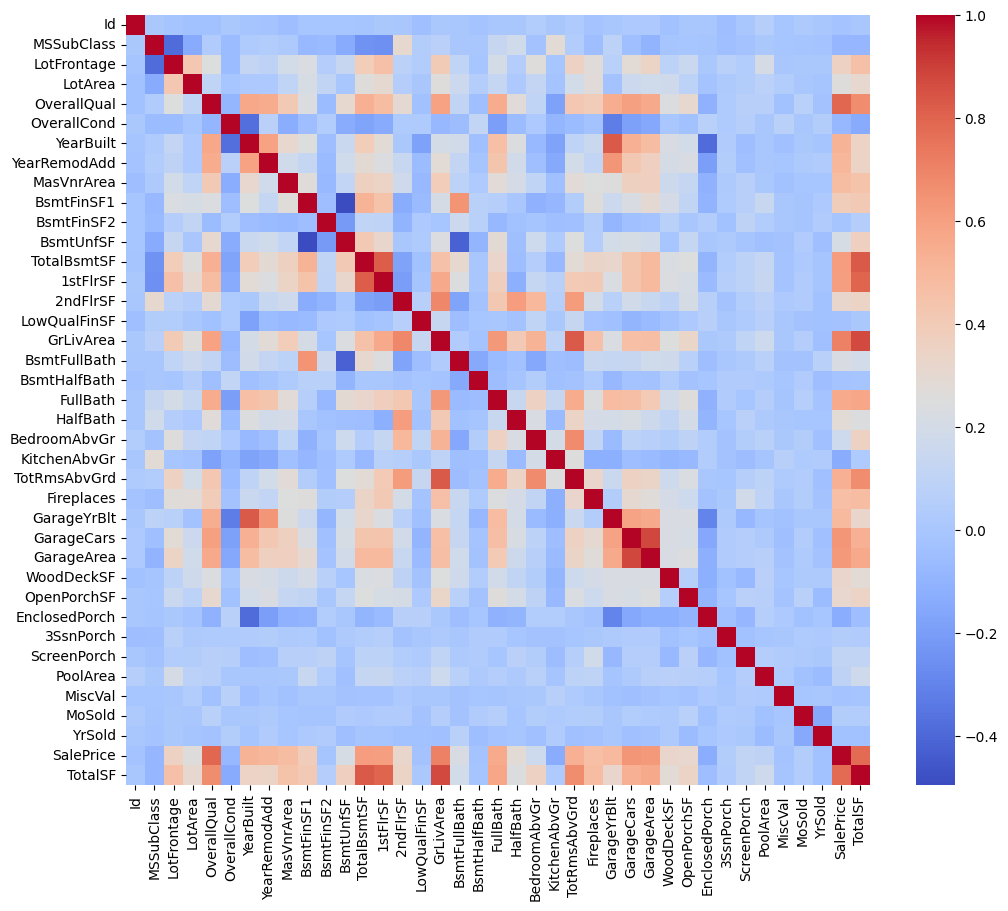

In [297]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
numeric_features = df.select_dtypes(include=[np.number])
corr = numeric_features.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.show()

Korelacijska matrika vseh numeričnih spremenljivk prikazuje, kako so spremenljivke med seboj povezane. Z njo lahko odkrijemo močne in šibke povezave med posameznimi spremenljivkami.
Na primer, TotalSF je močno povezan s prodajno ceno, kar potrjuje, da je velikost hiše eden glavnih dejavnikov, ki vplivajo na ceno.

Na prodajno ceno (SalePrice) imajo največji vpliv kakovost hiše (OverallQual), bivalna površina nad tlemi (GrLivArea), površina prvega nadstropja (1stFlrSF), skupna površina kleti (TotalBsmtSF), število garažnih mest (GarageCars) in velikost garaže (GarageArea). Vse te spremenljivke so s prodajno ceno močno pozitivno povezane, s korelacijami med 0,606 in 0,791.

The correlation matrix of all numerical variables shows how the variables are related to each other. It helps identify strong and weak relationships between variables.
For example, TotalSF is strongly correlated with the sale price, confirming that house size is a key factor influencing price.

The variables that have the strongest impact on SalePrice are house quality (OverallQual), above-ground living area (GrLivArea), first-floor area (1stFlrSF), total basement area (TotalBsmtSF), number of garage spaces (GarageCars), and garage size (GarageArea). All of these variables are strongly positively correlated with the sale price, with correlation values ranging from 0.606 to 0.791.

In [298]:
numeric_features.head(3)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalSF
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,61,0,0,0,0,0,2,2008,208500,2566
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,0,5,2007,181500,2524
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,42,0,0,0,0,0,9,2008,223500,2706


Izbrane spremenljivke ( features) zaradi visoke korelacije s ceno.

# **Učenje modela**

Linear RMSE: 39600.56, R2: 0.80
Ridge RMSE: 39599.15, R2: 0.80
Lasso RMSE: 39600.56, R2: 0.80
RandomForest RMSE: 30326.15, R2: 0.88


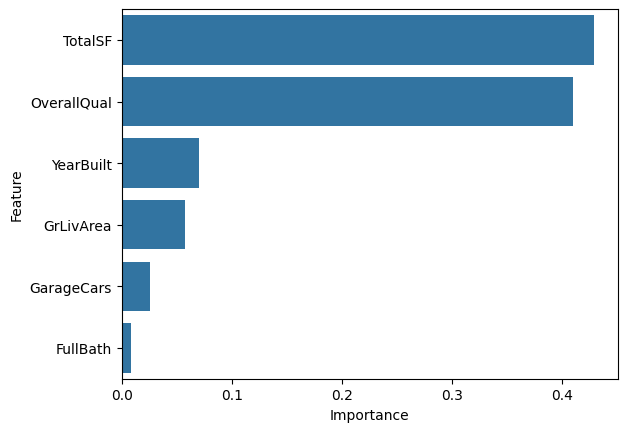

In [299]:
target = 'SalePrice'
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalSF', 'FullBath', 'YearBuilt']
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} RMSE: {rmse:.2f}, R2: {r2:.2f}")

rf = models['RandomForest']
importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importances)
plt.show()

Med preizkušenimi modeli za napovedovanje cen hiš je Random Forest dosegel najboljše rezultate, saj je napovedovalno napako zmanjšal na 30.300 in pojasnil 88 % variance v cenah, medtem ko so linearni modeli dosegli RMSE 39.600  in R2 0.80.

Among the models tested for predicting house prices, Random Forest achieved the best results, reducing the prediction error to 30,300 and explaining 88% of the variance in prices, while linear models reached an RMSE of 39,600 and an R² of 0.80.

# **Test**iranje naučenega modela

In [300]:
test_df = pd.read_csv('/content/sample_data/test.csv')
test_df['TotalSF'] = test_df.get('TotalBsmtSF', 0) + test_df.get('1stFlrSF', 0) + test_df.get('2ndFlrSF', 0)
for feat in ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalSF', 'FullBath', 'YearBuilt']:
    if feat not in test_df.columns:
        test_df[feat] = 0
X_test_final = test_df[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalSF', 'FullBath', 'YearBuilt']].fillna(0)

predictions = rf.predict(X_test_final)
test_df['PredictedSalePrice'] = predictions
test_df[['Id', 'PredictedSalePrice']].to_csv('house_price_predictions.csv', index=False)

In [301]:
testdf = pd.read_csv('/content/house_price_predictions.csv')
testdf.head(3)

,Id,PredictedSalePrice
0,1461,119245.733333
1,1462,154806.500000
2,1463,167864.580000


# **Učenje modela**

**TensorFlow Decision Forests (TF-DF)**

Next, I implemented a TensorFlow Decision Forests (TF-DF) model, which is based on Gradient Boosted Trees. I also added new features to the model, such as house age, the ratio of basement to total area, and room density. Gradient boosted tree models are particularly well-suited for tabular data because they can effectively capture nonlinear relationships and interactions between variables, which further improves prediction accuracy.

In [302]:
!pip install tensorflow_decision_forests --quiet
import tensorflow as tf
import tensorflow_decision_forests as tfdf

test_df['HouseAge'] = 2026 - test_df['YearBuilt']
test_df['BsmtRatio'] = test_df.get('TotalBsmtSF', 0) / test_df['TotalSF']
test_df['RoomsPerSF'] = test_df['GrLivArea'] / test_df['TotRmsAbvGrd']
for feat in features_tfdf:
    if feat not in test_df.columns:
        test_df[feat] = 0

X_test_tfdf = test_df[features_tfdf].fillna(0)
test_tfdf_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    pd.concat([X_test_tfdf, pd.Series(np.zeros(len(X_test_tfdf)), name="SalePrice")], axis=1),
    label="SalePrice",
    task=tfdf.keras.Task.REGRESSION
)
predictions_tfdf = tfdf_model.predict(test_tfdf_ds)
test_df['PredictedSalePrice_TFDF'] = predictions_tfdf
test_df[['Id', 'PredictedSalePrice_TFDF']].to_csv('house_price_predictions_tfdf.csv', index=False)


2/2 [==============================] - 0s 6ms/step


In [303]:
results_predictions = pd.read_csv('/content/house_price_predictions.csv')
results_predictions_tfdf = pd.read_csv('/content/house_price_predictions_tfdf.csv')

In [304]:
results_predictions.head(3)

,Id,PredictedSalePrice
0,1461,119245.733333
1,1462,154806.500000
2,1463,167864.580000


In [305]:
results_predictions_tfdf.head(3)

,Id,PredictedSalePrice_TFDF
0,1461,122474.57
1,1462,152665.11
2,1463,176230.69


In [306]:
comparison_df = pd.merge(
    results_predictions[['Id', 'PredictedSalePrice']],
    results_predictions_tfdf[['Id', 'PredictedSalePrice_TFDF']],
    on='Id',
    how='inner'
)

comparison_df['Difference_prediction'] = (
    comparison_df['PredictedSalePrice_TFDF'] - comparison_df['PredictedSalePrice']
)
comparison_df.head(3)

,Id,PredictedSalePrice,PredictedSalePrice_TFDF,Difference_prediction
0,1461,119245.733333,122474.57,3228.836667
1,1462,154806.500000,152665.11,-2141.390000
2,1463,167864.580000,176230.69,8366.110000


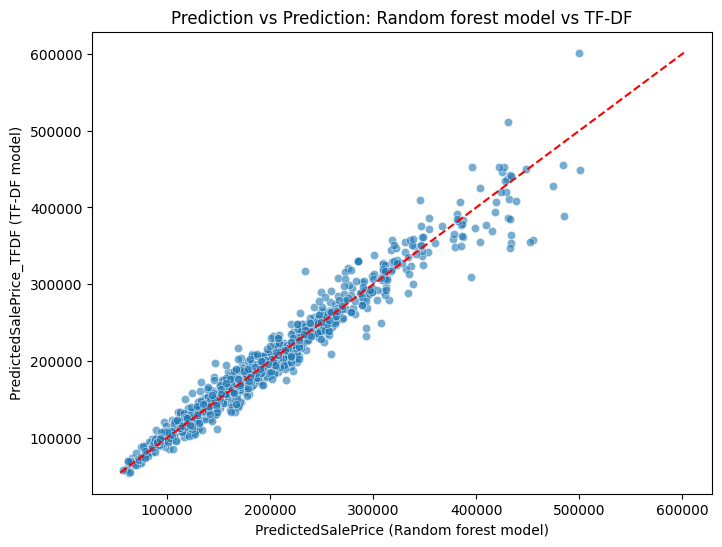

In [307]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=comparison_df['PredictedSalePrice'],
    y=comparison_df['PredictedSalePrice_TFDF'],
    alpha=0.6
)

min_val = min(comparison_df['PredictedSalePrice'].min(),
              comparison_df['PredictedSalePrice_TFDF'].min())
max_val = max(comparison_df['PredictedSalePrice'].max(),
              comparison_df['PredictedSalePrice_TFDF'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("PredictedSalePrice (Random forest model)")
plt.ylabel("PredictedSalePrice_TFDF (TF-DF model)")
plt.title("Prediction vs Prediction: Random forest model vs TF-DF")
plt.show()

Graf prikazuje primerjavo napovedanih cen med modeloma Random Forest in TF-DF ter kaže, da sta si modela zelo podobna. Večina točk leži blizu črtkane diagonalne črte, kar pomeni, da oba modela za iste primere napovedujeta skoraj enake vrednosti in da je med njunimi napovedmi visoka korelacija. Manjša odstopanja od diagonale kažejo na posamezne razlike v napovedih, vendar brez očitnega sistematičnega vzorca, kjer bi en model dosledno precenjeval ali podcenjeval vrednosti v primerjavi z drugim. Pri višjih cenah je opazna nekoliko večja razpršenost, kar nakazuje, da sta modela manj stabilna pri napovedovanju ekstremnih vrednosti. Na splošno lahko sklepamo, da Random Forest in TF-DF uporabljata podobne informacije iz podatkov in dosegata zelo primerljive rezultate.

The plot shows a comparison of predicted prices between the Random Forest and TF-DF models and indicates that the two models behave very similarly. Most points lie close to the dashed diagonal line, meaning that both models produce nearly identical predictions for the same observations and that there is a strong correlation between their outputs. Small deviations from the diagonal reflect minor differences in individual predictions, but there is no clear systematic pattern where one model consistently overestimates or underestimates values relative to the other. At higher price ranges, a slightly larger spread can be observed, suggesting that both models are less stable when predicting extreme values. Overall, the results imply that Random Forest and TF-DF rely on similar information from the data and achieve highly comparable performance.


# **Sklep / conclusion**

V analizi napovedovanja cen hiš so najboljši rezultati prišli iz drevesnih modelov, predvsem Random Forest in Gradient Boosted Trees (prek TensorFlow Decision Forests). Drevesni modeli so se izkazali za zelo učinkovite pri tabelaričnih podatkih, saj zajamejo nelinearne povezave in interakcije med spremenljivkami, kar povečuje natančnost napovedi. Dodatek novih značilnosti, kot so starost hiše, razmerje med kletjo in celotno površino ter gostota sob, je dodatno izboljšal napovedno moč modela. Analiza pomembnosti spremenljivk je pokazala, da velikost in kakovost hiše, površina bivalnega prostora in garaže močno vplivajo na prodajno ceno, kar potrjuje praktični pomen izbranih podatkovnih značilnosti. Skupno je uporaba naprednih drevesnih modelov v kombinaciji s premišljeno izbiro značilnosti omogočila robustno in natančno napovedovanje cen hiš.

In the house price prediction analysis, the best results came from tree-based models, particularly Random Forest and Gradient Boosted Trees (via TensorFlow Decision Forests). Tree-based models proved highly effective for tabular data because they can capture nonlinear relationships and interactions between variables, improving prediction accuracy. Adding new features, such as house age, the ratio of basement to total area, and room density, further enhanced the model’s predictive power. Feature importance analysis showed that house size and quality, living area, and garage characteristics strongly influence sale price, confirming the practical relevance of the selected features. Overall, using advanced tree-based models combined with carefully chosen features enabled robust and accurate house price predictions.

In [308]:
import ipywidgets as widgets
from IPython.display import display
def predict_price(overall_qual, gr_liv_area, garage_cars, total_sf, full_bath, year_built):
    import numpy as np

    input_df = pd.DataFrame({
        'OverallQual': [overall_qual],
        'GrLivArea': [gr_liv_area],
        'GarageCars': [garage_cars],
        'TotalSF': [total_sf],
        'FullBath': [full_bath],
        'YearBuilt': [year_built]
    })

    prediction = rf.predict(input_df)[0]
    print(f"Predicted House Price: ${prediction:,.2f}")

overall_qual_widget = widgets.IntSlider(value=5, min=1, max=10, description='OverallQual')
gr_liv_area_widget = widgets.IntText(value=1500, description='GrLivArea (sqft)')
garage_cars_widget = widgets.IntSlider(value=1, min=0, max=4, description='GarageCars')
total_sf_widget = widgets.IntText(value=2000, description='TotalSF')
full_bath_widget = widgets.IntSlider(value=2, min=0, max=4, description='FullBath')
year_built_widget = widgets.IntText(value=2000, description='YearBuilt')
predict_button = widgets.Button(description="Predict Price")


def on_predict_button_clicked(b):
    predict_price(
        overall_qual_widget.value,
        gr_liv_area_widget.value,
        garage_cars_widget.value,
        total_sf_widget.value,
        full_bath_widget.value,
        year_built_widget.value
    )

predict_button.on_click(on_predict_button_clicked)
widgets.VBox([
    overall_qual_widget,
    gr_liv_area_widget,
    garage_cars_widget,
    total_sf_widget,
    full_bath_widget,
    year_built_widget,
    predict_button
])

Predicted House Price: $148,774.07
Predicted House Price: $148,774.07
Predicted House Price: $144,071.75
